## Introduction
Code written by Matthew DeVerna and Evelyn Delph



In [ ]:
import networkx as nx
import numpy as np
import random as rn
import matplotlib.pyplot as plt
import pickle as pkl
import seaborn as sns
import pandas as pd
# from simulation import Simulation
# sns.set_style('dark')

In [ ]:
# read in graph with node attributes
G = nx.read_graphml('../contact_network.graphml',node_type=str)

In [ ]:
# confirm the retweets were preserved
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 385
Number of edges: 1466
Average degree:   7.6156


## Simulation

In [ ]:
class SIR(object):

    def __init__(
        self,
        G,
        infected_threshold,
        proportion_recovered,
        beta,
        mu,
        days
    ):
        """
        Initialize model parameters
        
        Parameters:
        - G (networkx.Graph) : Graph used for modeling
        - infected_threshold (int) : number of retweets a user/node must've shared
            to be labeled as "infected" in the initial state
        - proportion_recovered (float) : proportion of people to label as "recovered"
            during the initial state. This allows for the simulation of different
            levels of vaccine coverage in the population. 
        - beta (float) : the average number of people infected by an already infected
            individual
        - mu (float) : the probability of moving from the infected state to the
            recovered state at any given time
        - days (int) : number of days (discrete timesteps) to run our simulation
        """
        
        self.G = G
        self.infected_threshold = infected_threshold
        self.proportion_recovered = proportion_recovered 
        self.beta = beta
        self.mu = mu
        self.days = days
    
    def initial_state(self):
        """
        Set the initial state of the network.
        
        Parameters Utilized:
            - G
            - infected_threshold
            - proportion_recovered
        
        Returns
            - state (dict) : the initial infection state; where
                keys = nodes and values = their state (i.e., S, I, or R)
                
        """
        
        # Select the infected nodes for initial state based on the threshold
        nodes_infected = set([node for node in self.G.nodes if self.G.nodes[node]['retweet_counts'] > self.infected_threshold])
#         percent_infected = len(nodes_infected)/self.G.number_of_nodes()
        
        # Identify the remaining susceptible users, and determine how many need to be set as "recovered"
        susceptible = list(set(self.G.nodes).difference(nodes_infected))
        num_recovered = int(len(susceptible)*self.proportion_recovered)
        
        ### Assign the state of each node ###
        state = {}
        
        # Set infected nodes
        for node in nodes_infected:
            state[node] = "I"

        # Randomly shuffle susceptible nodes, and set the first `num_recovered`
        # nodes as recovered. All others set as susceptible
        rn.shuffle(susceptible)
        for idx,node in enumerate(susceptible):
            if idx <= num_recovered:
                state[node] = "R"
            else:
                state[node] = "S"
        return state

    def state_transition(self,current_state):
        """
        Execute a single timestep's state transition.
        
        Paramters Utilized:
            - current_state (dict) : the network's current infection state; where
                keys = nodes and values = their state (i.e., S, I, or R)
            - G
            - beta
            - mu 
        
        Returns:
            - next_state (dict) : the updated infection state; where
                keys = nodes and values = their state (i.e., S, I, or R)
        """
        # Copy current state
        next_state = current_state.copy()
        
        # Get and randomize list of all nodes
        all_nodes = list(self.G.nodes)
        rn.shuffle(all_nodes)
        
        for node in all_nodes:
            
            # If node is susceptible, set node state as "infected" with probability = beta
            # for each neighbor whose state is "infected" 
            if current_state[node] == 'S':
                for neighbor in self.G.neighbors(node):
                    if current_state[neighbor] == 'I':
                        if rn.random() < self.beta:
                            next_state[node] = 'I'
            
            # Otherwise, if node state is "infected", move it to the "recovered" state
            # with probability = mu
            elif current_state[node] == 'I':
                if rn.random() < self.mu:
                    next_state[node] = 'R'

        return next_state

    def run(self):
        """
        Run the simulation for self.days time steps
        
        Parameters Utilized:
            - initial_state
            - days
        
        Returns:
            - runs (dict) : a dictionary where 
        """
        current_state = self.initial_state()
        runs = {}
        for _ in range(self.days):
            new_state = self.state_transition(current_state)
            runs[_] = new_state
            current_state = new_state
        return runs

In [ ]:
def run_SIR_simulations(
    num_sims_per_state,
    G,
    infected_threshold,
    proportion_recovered,
    beta,
    mu,
    days
):
    """
    Run X simulations of the SIR model given the provided conditions utilizing
        the SIR class.
    
    Parameters:
        - num_sims_per_state (int) : number of simulations to run
        - G (networx.Graph) : network to operate on
        - infected_threshold (int) : number of retweets a user/node must've shared
            to be labeled as "infected" in the initial state
        - proportion_recovered (float) : proportion of people to label as "recovered"
            during the initial state. This allows for the simulation of different
            levels of vaccine coverage in the population.
        - beta (float) : the average number of people infected by an already infected
            individual
        - mu (float) : the probability of moving from the infected state to the
            recovered state at any given time
        - days (int) : number of days (discrete timesteps) to run our simulation
    
    Return:
        - simulations (dict) : a dictionary containing the total number of 
            susceptible, infected, and recovered individuals at each time step
            for all simulations.
            - keys = simulation number
            - values = a nested dictionary where the keys are S, I, or R, and the
                values for each are temporally ordered lists which represent
                the total number of individuals in that state at that time step.
    """
    # Create simulations dictionary to store all simulation data
    simulations = {}

    for sim in range(num_sims_per_state):
        # Initialize model
        model = SIR(
            G,
            infected_threshold,
            proportion_recovered,
            beta,
            mu,
            days
        )
        # Run single simulation
        indiv_sim = model.run()

        # Create empty lists to fill with count of people in each
        # state for each time step
        all_sus_totals = []
        all_inf_totals = []
        all_rec_totals = []

        for t_step, indiv_state in indiv_sim.items():

            # Count number of people in each state at this time step
            state_values = list(indiv_state.values())
            total_susceptible = state_values.count('S')
            total_infected = state_values.count('I')
            total_recovered = state_values.count('R')

            # Add the individual counts at this state to the larger list of totals
            all_sus_totals.append(total_susceptible)
            all_inf_totals.append(total_infected)
            all_rec_totals.append(total_recovered)

        # Add the totals to the simulation data dictionary
        simulations[sim] = {
            'S':all_sus_totals,
            'I':all_inf_totals,
            'R':all_rec_totals
        }
    return simulations

def calculate_mean_vals_at_each_tstep(num_sims_per_state, days, simulations):
    """
    Convert the simulations dictionary to a dataframe containing
        only the mean values at each time step. 
    
    Parameters:
        - num_sims_per_state (int) : number of simulations
        - days (int) : number of time steps
    
    Return:
        - data (pd.DataFrame) : mean values at each state for susceptible,
            infected, and recovered
    """
    # Intialize matrices to fill with values from our simulation data
    matrix_shape = (num_sims_per_state, days)
    S = np.zeros(shape=matrix_shape)
    I = np.zeros(shape=matrix_shape)
    R = np.zeros(shape=matrix_shape)
    
    # Place values into the matrices
    idx = 0
    for key,value in simulations.items():
        S[idx] = np.array(value['S'])
        I[idx] = np.array(value['I'])
        R[idx] = np.array(value['R'])
        idx += 1
    
    # Calculate mean and std
    S_mean = S.mean(axis=0)
    I_mean = I.mean(axis=0)
    R_mean = R.mean(axis=0)
    S_std = S.std(axis=0)
    I_std = I.std(axis=0)
    R_std = R.std(axis=0)
    
    # Convert to pandas datafrane
    data = pd.DataFrame({
        "mean_susceptible" : S_mean,
        "mean_infected" : I_mean,
        "mean_recovered" : R_mean,
        "std_susceptible" : S_std,
        "std_infected" : I_std,
        "std_recovered" : R_std
    })
    return data

In [ ]:
def plot_infected(data, inf_thresh, prop_recovered):
    sns.lineplot(
        x = np.arange(1,DAYS+1),
        y = mean_vals["mean_infected"],
        label = f"Mean Infected | Inf. Threshold = {inf_thresh}, Rec. Proportion = {prop_recovered}"
    )
    plt.ylabel("Proportion of People Infected")
    plt.xlabel("Days")
    plt.grid(axis = "y")
    sns.despine(left = True)

In [ ]:
# Create lists to fill with data
max_infs = []
std_infs = []
max_days = []
prop_rec = []
inf_thresh = []

# Set simulation parameters
beta=.28
mu = .15
days = 50
num_sims_per_state = 100

# Set different levels of opinion thresholds and vaccine coverage to run simulations
infected_thresholds = np.arange(1,16,2)
proportions_recovered = np.linspace(.1,1.0,7)

print("Opinion (RT Misinfo.) Thresholds",infected_thresholds)
print("Vaccination Coverage Levels",proportions_recovered)

# Loop through each combination of these variables
for infected_threshold in infected_thresholds:
    for proportion_recovered in proportions_recovered:
        
        # Run all simulations
        simulations = run_SIR_simulations(
            num_sims_per_state,
            G,
            infected_threshold,
            proportion_recovered,
            beta,
            mu,
            days
        )
        
        # Check that for ecah day in each simulation we have
        # the correct number of nodes in our network
        for sim_num in range(num_sims_per_state):
            for day in range(days):
                if (simulations[sim_num]["S"][day] + simulations[sim_num]["I"][day] + simulations[sim_num]["R"][day]) != 385:
                    print("Theres something wrong here...")
                    break
        
        # Calculate mean and stds
        data_vals = calculate_mean_vals_at_each_tstep(num_sims_per_state, days, simulations)
        data_vals = data_vals / len(G.nodes)
        
        # Add mean max infected and stds to our lists as well as the
        # simulations variable settings
        max_infs.append(data_vals["mean_infected"].max())
        max_day = data_vals["mean_infected"].idxmax()
        max_days.append(max_day)
        std_infs.append(data_vals.loc[max_day, "std_infected"])
        prop_rec.append(proportion_recovered)
        inf_thresh.append(infected_threshold)

# Convert everything to a data frame
max_data = pd.DataFrame({
    "maximum_infected" : max_infs,
    "std_max_infected" : std_infs,
    "day_of_max_infection" : max_days,
    "infected_threshold" : inf_thresh,
    "proportion_vaccinated" : prop_rec 
})

# Round these for cleaner plotting later
max_data["proportion_vaccinated"] = np.round(max_data["proportion_vaccinated"],2)

Opinion (RT Misinfo.) Thresholds [ 1  3  5  7  9 11 13 15]
Vaccination Coverage Levels [0.1  0.25 0.4  0.55 0.7  0.85 1.  ]


### Plot the contact network's degree distribution

In [ ]:
from collections import Counter

all_degrees = [deg for node,deg in list(dict(G.degree()).items())]
deg_map = Counter(all_degrees)

degrees = list(deg_map.keys())
degrees.sort()

counts = [deg_map[deg] for deg in degrees]

In [ ]:
path = "../contact_network_low_cred_share_freq.csv"

problem_users = pd.read_csv(path, dtype={"user_ids":str})

In [ ]:
user_degree = []
for user in problem_users["user_ids"]:
    user_degree.append((user,G.degree[user]))

In [ ]:
problem_users = problem_users.merge(pd.DataFrame(user_degree, columns = ["user_ids", "degree"]), on = "user_ids")


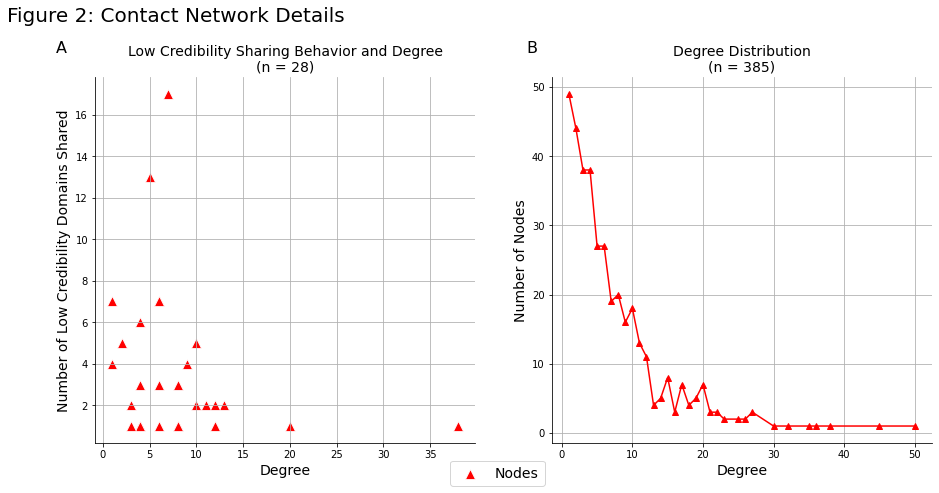

In [ ]:
plt.figure(figsize=(15,7))

plt.subplot(121)
sns.scatterplot(
    data = problem_users,
    x = "degree",
    y = "num_domains_shared",
    marker = "^",
    alpha = 1,
    s = 100,
    color = "red"
)
plt.text(x = -5, y= 19, s = "A", fontsize = 16)

plt.xlabel("Degree", fontsize = 14)
plt.ylabel("Number of Low Credibility Domains Shared", fontsize = 14)
plt.title(f"Low Credibility Sharing Behavior and Degree\n(n = {len(problem_users)})", fontsize = 14)
plt.legend(["Nodes"], bbox_to_anchor=(1.2, -.03), fontsize = 14)
plt.grid()
sns.despine()

plt.subplot(122)
plt.plot(degrees, counts, "^-", color = "red")
plt.ylabel("Number of Nodes", fontsize = 14)
plt.xlabel("Degree", fontsize = 14)
plt.title(f"Degree Distribution\n(n = {sum(counts)})", fontsize = 14)
plt.text(x = -5, y= 55, s = "B", fontsize = 16)

sns.despine()
plt.grid()
# plt.xscale("log")
# plt.yscale("log")

plt.suptitle("Figure 2: Contact Network Details", fontsize = 20, x = .2, y =.99)
plt.subplots_adjust(top = .85)

### Visualize the Network

In [ ]:
colors = []
for node in list(G.nodes()):
    if G.nodes[node]["retweet_counts"] >0:
        colors.append("red")
    else:
        colors.append("blue")

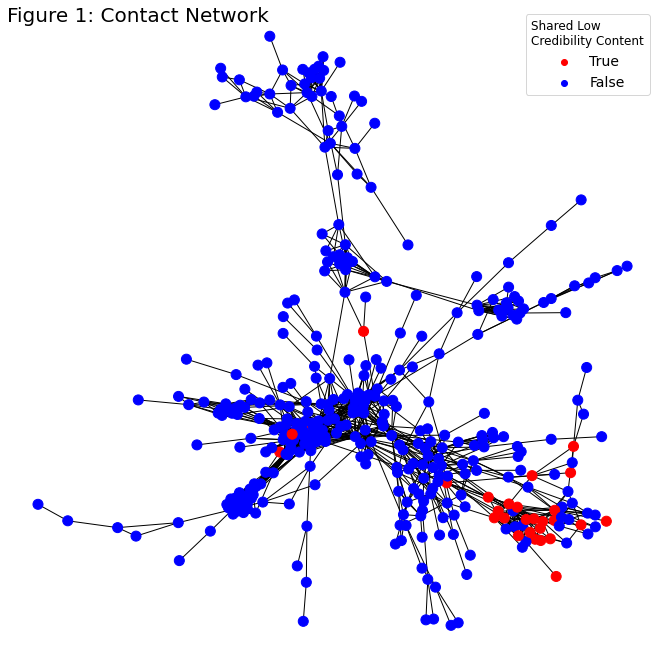

In [ ]:
plt.figure(figsize=(9,9))

pos = nx.drawing.layout.spring_layout(G)

nx.draw(G, pos = pos, node_size = 100, node_color=colors)

plt.scatter([],[], color = "red", label = "True")
plt.scatter([],[], color = "blue", label = "False")
legend = plt.legend(title="Shared Low\nCredibility Content", fontsize = 14)
plt.setp(legend.get_title(),fontsize='large')

plt.suptitle("Figure 1: Contact Network", fontsize = 20, x = .2, y =1)
plt.subplots_adjust(top = .8)

In [ ]:
avg_k = np.mean(list(dict(G.degree).values()))
print(f"Average Degree = {avg_k}")

Average Degree = 7.615584415584416


In [ ]:
max_data.head()

,maximum_infected,std_max_infected,day_of_max_infection,infected_threshold,proportion_vaccinated
0,0.297013,0.062812,9,1,0.10
1,0.211844,0.052745,11,1,0.25
2,0.119662,0.069439,10,1,0.40
3,0.055506,0.044729,10,1,0.55
4,0.049922,0.005590,0,1,0.70


### Calculate correlations

In [ ]:
import scipy

In [ ]:
x_vals = ["proportion_vaccinated", "infected_threshold"]
y_vals = ["maximum_infected", "day_of_max_infection"]

for x in x_vals:
    for y in y_vals:
        r,p = scipy.stats.pearsonr(max_data["maximum_infected"], max_data["infected_threshold"])
        print(f"{x} and {y}\n\t| r = {r} and p = {p}")

proportion_vaccinated and maximum_infected
	| r = -0.08352439531237264 and p = 0.5405292454429212
proportion_vaccinated and day_of_max_infection
	| r = -0.08352439531237264 and p = 0.5405292454429212
infected_threshold and maximum_infected
	| r = -0.08352439531237264 and p = 0.5405292454429212
infected_threshold and day_of_max_infection
	| r = -0.08352439531237264 and p = 0.5405292454429212


In [ ]:
print(f"Proportion of nodes that shared low credibility content: {28/385}")

Proportion of nodes that shared low credibility content: 0.07272727272727272


In [ ]:
mean_prob_shares = problem_users["num_domains_shared"].mean()
print(f"Mean num low cred sources shared = {mean_prob_shares}")

Mean num low cred sources shared = 3.7142857142857144


In [ ]:
std_prob_share = problem_users["num_domains_shared"].std()
print(f"STD of low cred sources shared = {std_prob_share}")

STD of low cred sources shared = 3.818639886400729


In [ ]:
def plot_max_infected(with_error_bars = False):
#     with_error_bars = False

#     plt.figure(figsize=(10,10))

    marks = ["^", "P", "o", "s", "d","<", ">"]
    colors = ["black", "brown", "orange", "red", "purple", "green", "blue"]

    vax_cov = list(max_data["proportion_vaccinated"].unique())
    vax_cov.sort()
    vax_cov.reverse()
    zipper = zip(vax_cov, marks, colors)

    for prop, mark, col in zipper:
        #create basic scatterplot
        df = max_data.loc[max_data["proportion_vaccinated"] == prop]

        if with_error_bars:
            plt.errorbar(
                df["infected_threshold"], df["maximum_infected"], df["std_max_infected"],
                 marker = mark, color = col, capsize = 10,
                linestyle = '', markersize = 10, label = f"{prop}"
            )

        else:
            plt.plot(
                df["infected_threshold"], df["maximum_infected"],
                 marker = mark, color = col,
                linestyle = '', markersize = 10, label = f"{prop}")

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(df["infected_threshold"], df["maximum_infected"], 1)

        #add linear regression line to scatterplot 
        plt.plot(df["infected_threshold"], m*df["infected_threshold"]+b, color = col)

    plt.title("Maximum Proportion of Population Infected\nas a Function of Opinion Threshold and Vaccination Coverage\n(100 simulations per initial state)", fontsize = 14)
    plt.ylabel("Mean Maximum Proportion of Population Infected", fontsize = 14)
    plt.xlabel("Opinion Threshold\n(User shared low-credibility sources at least this many times)", fontsize = 14)
#     plt.legend(title = "Vaccination Coverage", bbox_to_anchor=(1, .65))
    sns.despine()
    plt.grid()

In [ ]:
def plot_by_day():
#     plt.figure(figsize=(12,12))

    marks = ["^", "P", "o", "s", "d","<", ">"]
    colors = ["black", "brown", "orange", "red", "purple", "green", "blue"]

    vax_cov = list(max_data["proportion_vaccinated"].unique())
    vax_cov.sort()
    vax_cov.reverse()
    zipper = zip(vax_cov, marks, colors)

    for prop, mark, col in zipper:
        #create basic scatterplot
        df = max_data.loc[max_data["proportion_vaccinated"] == prop]
        plt.plot(
            df["infected_threshold"], df["day_of_max_infection"],
             marker = mark, color = col,
            linestyle = '', markersize = 10, label = f"{prop}")

        #obtain m (slope) and b(intercept) of linear regression line
        m, b = np.polyfit(df["infected_threshold"], df["day_of_max_infection"], 1)

        #add linear regression line to scatterplot 
        sns.lineplot(x = df["infected_threshold"],
                    y = m*df["infected_threshold"]+b,
                    ci = 95, color = col)

    plt.title("Mean day of Infection Peak\nas a Function of Opinion Threshold and Vaccination Coverage\n(100 simulations per initial state)", fontsize = 14)
    plt.ylabel("Mean Day of Infection Peak", fontsize = 14)
    plt.xlabel("Opinion Threshold\n(User shared low-credibility sources at least this many times)", fontsize = 14)
    plt.legend(title = "Vaccination Coverage", bbox_to_anchor=(1, .65))
    sns.despine()
    plt.grid()

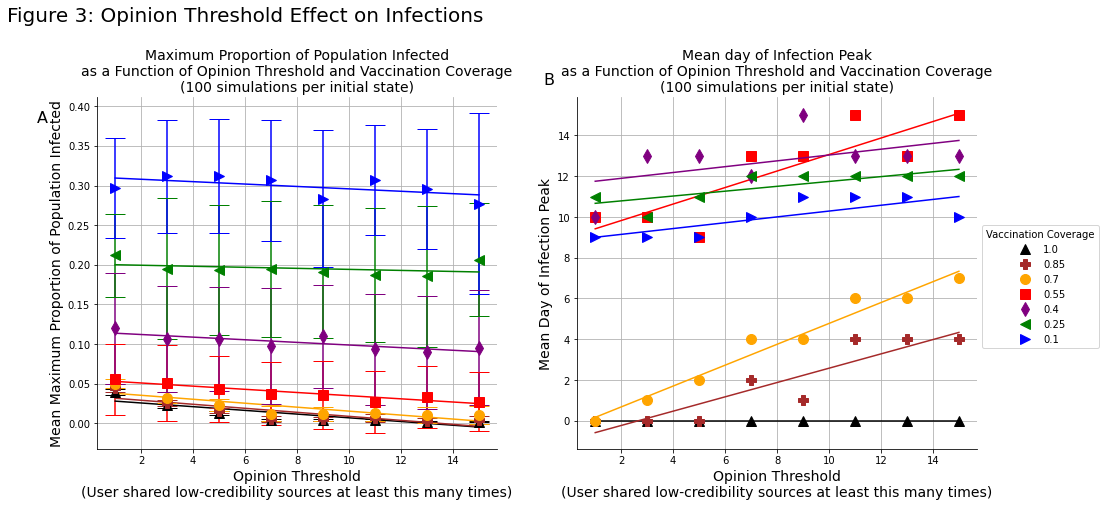

In [ ]:
plt.figure(figsize=(15,7))
plt.subplot(121)
plt.text(x = -2, y= .38, s = "A", fontsize = 16)
plot_max_infected(True)
plt.subplot(122)
plot_by_day()
plt.text(x = -1, y= 16.5, s = "B", fontsize = 16)

plt.suptitle("Figure 3: Opinion Threshold Effect on Infections", fontsize = 20, x = .2, y =1)

plt.tight_layout()
plt.subplots_adjust(top = .82, wspace=.2)

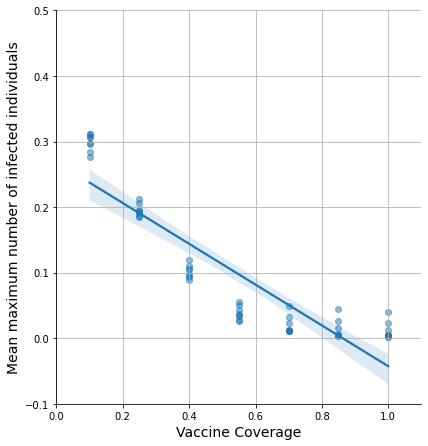

In [ ]:
sns.lmplot(
    data = max_data,
    x = "proportion_vaccinated",
    y = "maximum_infected",
    markers = "o",
    scatter_kws = {"alpha" : .5},
    height = 6
)
plt.ylim(-.1,.5)
plt.xlim(0,1.1)
plt.xlabel("Vaccine Coverage", fontsize = 14)
plt.ylabel("Mean maximum number of infected individuals", fontsize = 14)
plt.grid()

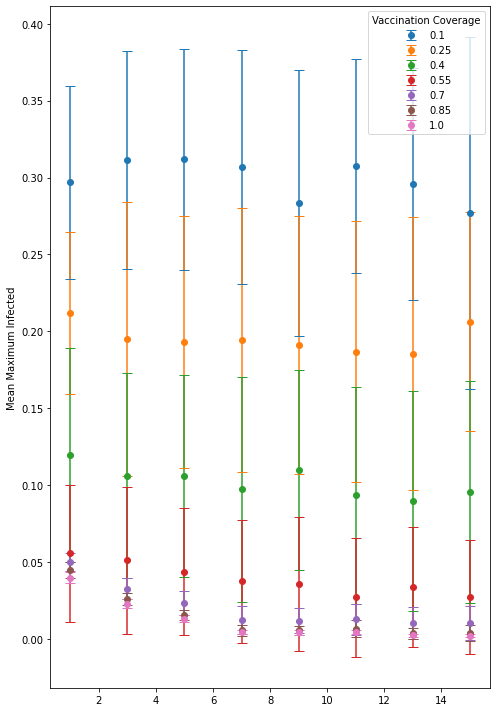

In [ ]:
plt.figure(figsize=(7,10))

for idx, val in enumerate(max_data["proportion_vaccinated"].unique()):
#     plt.subplot(len(max_data["proportion_vaccinated"].unique()),1,idx+1)
    df = max_data[max_data["proportion_vaccinated"] == val]
    plt.errorbar(df["infected_threshold"],
                 df["maximum_infected"],
                 df["std_max_infected"], 
                 fmt ="o", capsize=5, label = f"{val}")


plt.legend(title = "Vaccination Coverage", loc = "best")
plt.ylabel("Mean Maximum Infected")
plt.tight_layout()

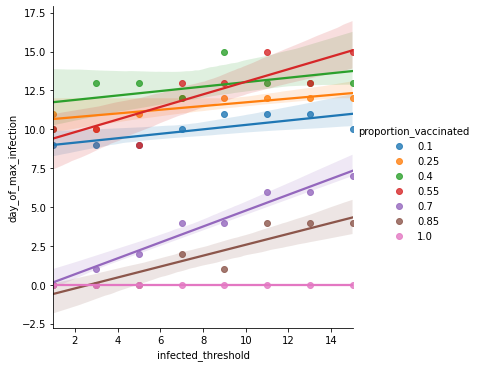

In [ ]:
sns.lmplot(data = max_data,
           x = "infected_threshold", 
           y = "day_of_max_infection", 
           hue = "proportion_vaccinated"
          )

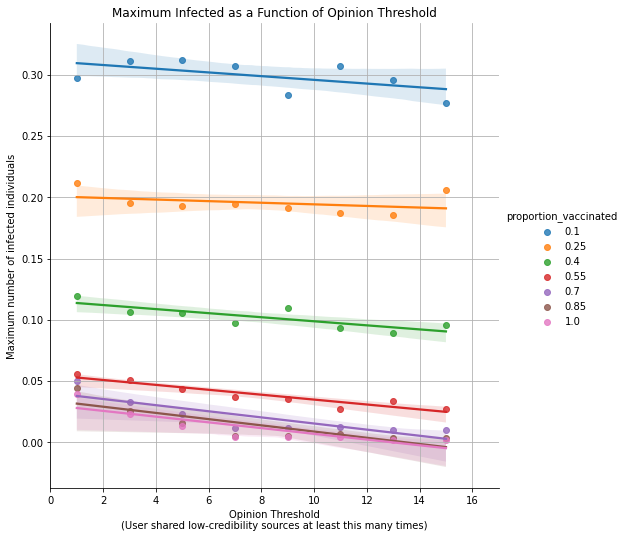

In [ ]:
sns.lmplot(
    data = max_data,
    x = "infected_threshold",
    y = "maximum_infected", 
    hue = "proportion_vaccinated",
    height = 7
)
plt.xlim(0,17)
plt.title("Maximum Infected as a Function of Opinion Threshold")
plt.xlabel("Opinion Threshold\n(User shared low-credibility sources at least this many times)")
plt.ylabel("Maximum number of infected individuals")
plt.grid()